In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#
# VGG 16
#

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import os

# # Set paths
train_dir = '/content/drive/MyDrive/MV_MiniProject/data'
val_dir = '/content/drive/MyDrive/MV_MiniProject/val_data'

In [ ]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 200
EPOCHS = 10
NUM_CLASSES = 4

# Data preprocessing with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    )

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4806 images belonging to 4 classes.
Found 825 images belonging to 4 classes.


In [ ]:
# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
import time
start_time = time.time()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

# Evaluate
loss, acc = model.evaluate(val_gen)
print(f"VGG Validation Accuracy: {acc*100:.2f}%")
end_time = time.time()
execution_time = end_time - start_time
print(f"<---Execution Time: {execution_time/60:.6f} minutes")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.2890 - loss: 2.7245 - val_accuracy: 0.2461 - val_loss: 1.3595
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.3705 - loss: 1.2961 - val_accuracy: 0.6327 - val_loss: 1.2355
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.4642 - loss: 1.1666 - val_accuracy: 0.6521 - val_loss: 1.0681
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5506 - loss: 1.0483 - val_accuracy: 0.6933 - val_loss: 0.9087
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6093 - loss: 0.9225 - val_accuracy: 0.7030 - val_loss: 0.7887
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.6295 - loss: 0.8373 - val_accuracy: 0.9527 - val_loss: 0.6512
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6594 - loss: 0.7703 - val_accuracy: 0.9176 - val_loss: 0.6229
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6624 - loss: 0.7443 - val_accuracy: 0.9600 - val_los

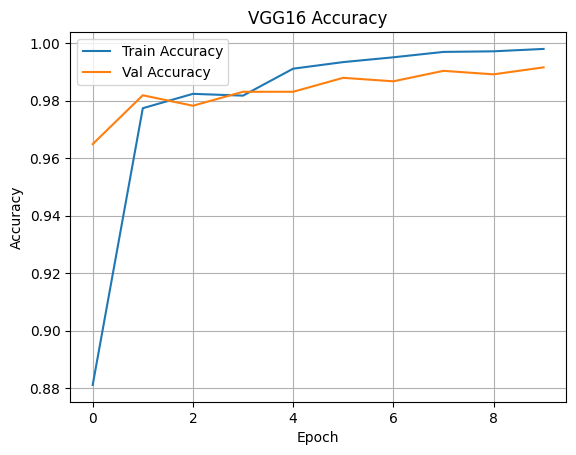

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('VGG16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:
model.save("vgg16_satellite_model.keras")


In [ ]:
#
# MobileNetV2
#

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths to dataset
train_dir = '/content/drive/MyDrive/MV_MiniProject/data'
val_dir = '/content/drive/MyDrive/MV_MiniProject/val_data'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE =200
EPOCHS = 10
NUM_CLASSES = 4

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    )
plain_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Non-augmented generators (same data, no rotation/flip/zoom)
train_gen_no_aug = plain_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_gen_no_aug = plain_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

Found 4806 images belonging to 4 classes.
Found 825 images belonging to 4 classes.
Found 4806 images belonging to 4 classes.
Found 825 images belonging to 4 classes.


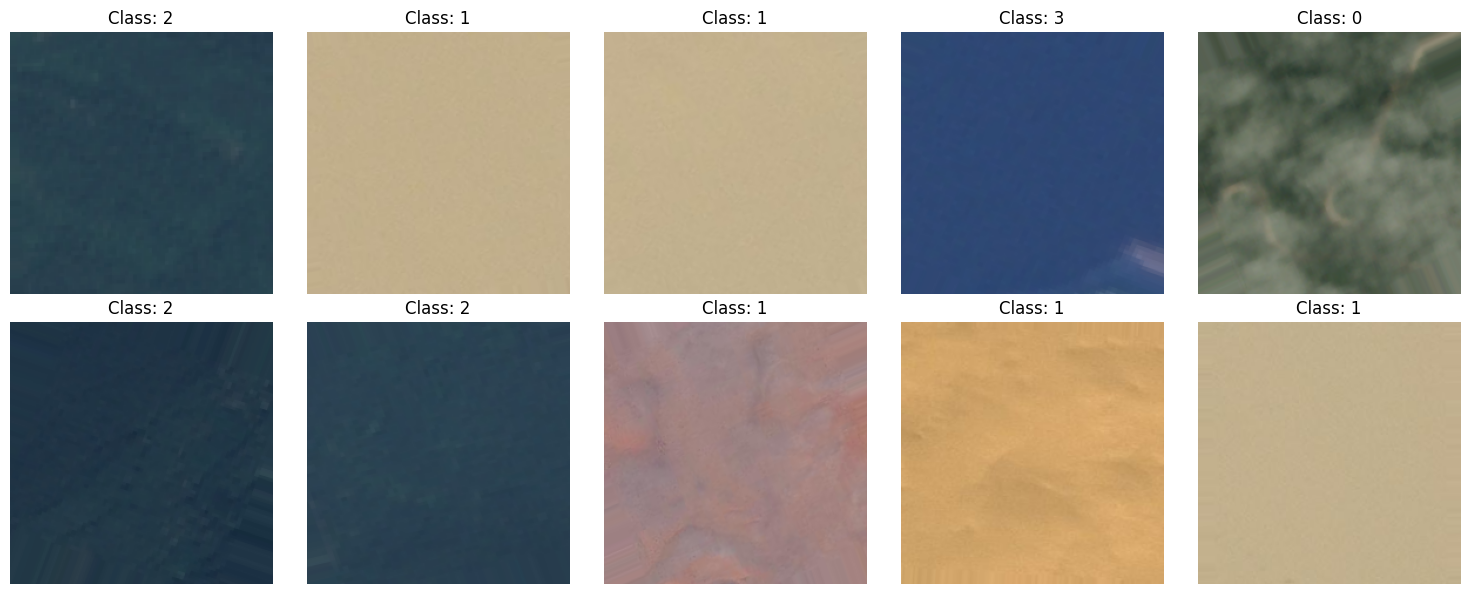

In [ ]:
# Display a batch of augmented images
import numpy as np

# Get one batch of augmented images and labels
images, labels = next(train_gen)

# Plot 10 images from the batch
plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1016s 40s/step - accuracy: 0.5845 - loss: 1.9612 - val_accuracy: 0.9636 - val_loss: 0.2136
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9284 - loss: 0.2291 - val_accuracy: 0.9612 - val_loss: 0.1319
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9569 - loss: 0.1413 - val_accuracy: 0.9770 - val_loss: 0.0945
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9444 - loss: 0.1624 - val_accuracy: 0.9673 - val_loss: 0.1002
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9692 - loss: 0.1023 - val_accuracy: 0.9042 - val_loss: 0.2392
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9498 - loss: 0.1387 - val_accuracy: 0.9685 - val_loss: 0.0931
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9678 - loss: 0.0975 - val_accuracy: 0.9321 - val_loss: 0.2055
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9596 - loss: 0.1308 - val_accuracy: 0.9673 - val_lo

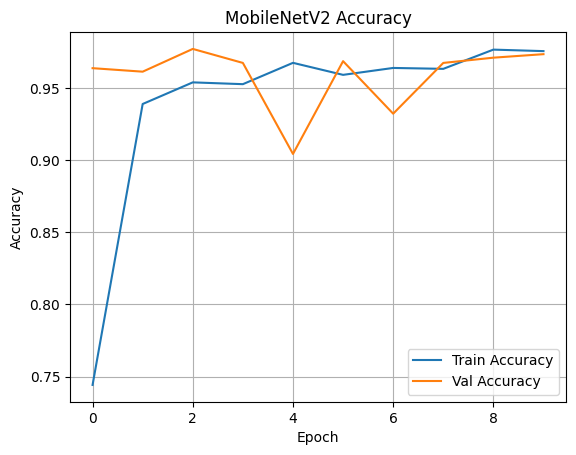

In [ ]:
import time
start_time = time.time()
# Compile
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

# Evaluate
loss, acc = model.evaluate(val_gen)
print(f"\n Validation Accuracy: {acc * 100:.2f}%")
end_time = time.time()
execution_time = end_time - start_time
print(f"<---Execution Time: {execution_time/60:.6f} minutes")
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2896 - loss: 9.3472 - val_accuracy: 0.5406 - val_loss: 1.0352
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 954ms/step - accuracy: 0.7490 - loss: 0.7599 - val_accuracy: 0.7333 - val_loss: 0.5959
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 951ms/step - accuracy: 0.8074 - loss: 0.5516 - val_accuracy: 0.7976 - val_loss: 0.5341
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 957ms/step - accuracy: 0.8246 - loss: 0.3953 - val_accuracy: 0.7612 - val_loss: 0.5961
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 965ms/step - accuracy: 0.8928 - loss: 0.3452 - val_accuracy: 0.9103 - val_loss: 0.2690
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 995ms/step - accuracy: 0.8933 - loss: 0.2899 - val_accuracy: 0.9333 - val_loss: 0.2100
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 932ms/step - accuracy: 0.9344 - loss: 0.1811 - val_accuracy: 0.9224 - val_loss: 0.2011
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 998ms/step - accuracy: 0.9285 - loss: 0.2124 - val_accurac

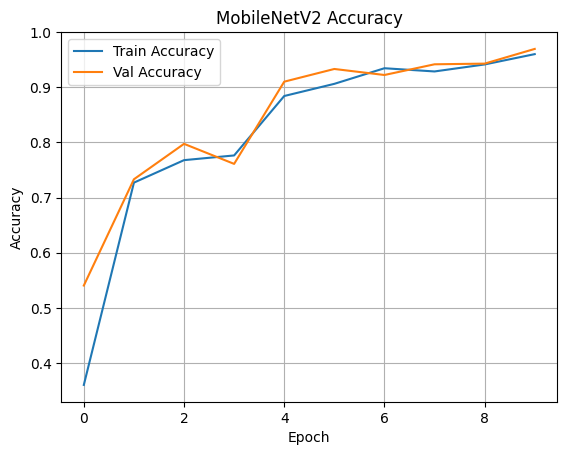

In [ ]:
  ####---------without augmentation
import time
start_time = time.time()
# Compile
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen_no_aug, validation_data=val_gen_no_aug, epochs=EPOCHS)

# Evaluate
loss, acc = model.evaluate(val_gen)
print(f"\n Validation Accuracy: {acc * 100:.2f}%")
end_time = time.time()
execution_time = end_time - start_time
print(f"<---Execution Time: {execution_time/60:.6f} minutes")


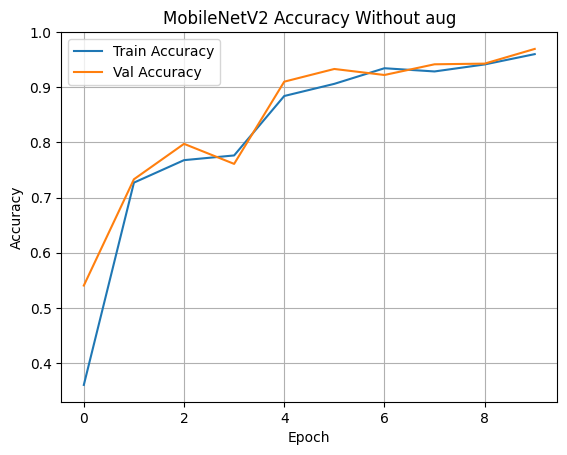

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 Accuracy Without aug')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluating real time image


In [ ]:
model.save("mobilenetv2_satellite_model.h5")
model.save("mobil_satellite_model.keras")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


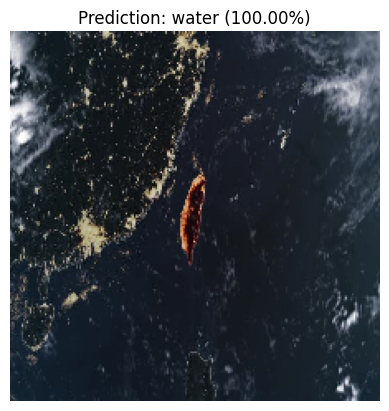

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("/content/drive/MyDrive/MV_MiniProject/mobil_satellite_model.keras")

class_names = ['cloudy', 'desert', 'green_area', 'water']

#load and preprocess image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index] * 100
    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    return predicted_class, confidence

# Test image
image_path = "/content/gettyimages-1477662805-640x640.jpg"
predicted_class, confidence = predict_image(image_path)



5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


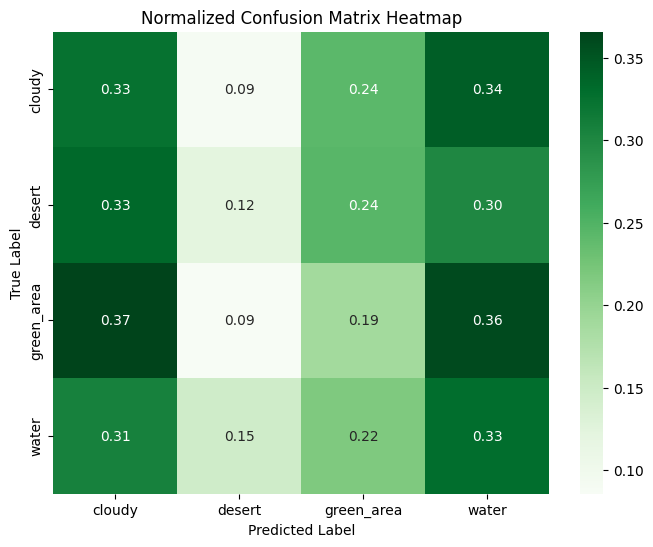

Classification Report:

              precision    recall  f1-score   support

      cloudy       0.34      0.33      0.33       280
      desert       0.12      0.12      0.12        90
  green_area       0.18      0.19      0.18       175
       water       0.33      0.33      0.33       280

    accuracy                           0.28       825
   macro avg       0.24      0.24      0.24       825
weighted avg       0.28      0.28      0.28       825



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict labels for validation data
val_gen.reset()
predictions = model.predict(val_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes

# Get class labels
class_labels = list(val_gen.class_indices.keys())

# Normalized confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix Heatmap')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)


{'h': 1, 'e': 1, 'l': 3, 'o': 2, ' ': 1, 'w': 1, 'r': 1, 'd': 1}


Counter({'l': 3, 'o': 2, 'h': 1, 'e': 1, ' ': 1, 'w': 1, 'r': 1, 'd': 1})
